In [ ]:
# Core packages
!pip install -q kaggle timm scikit-learn seaborn albumentations matplotlib pillow onnx

# Install ONNX Runtime with Python 3.11 support
!pip install -q onnxruntime==1.20.0

# Verify
import torch, timm, onnx, onnxruntime, sklearn
print("torch:", torch.__version__)

print("timm:", timm.__version__)
print("onnx:", onnx.__version__)
print("onnxruntime:", onnxruntime.__version__)
print("sklearn:", sklearn.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.2 MB/s eta 0:00:00
torch: 2.9.0+cu126
timm: 1.0.22
onnx: 1.20.0
onnxruntime: 1.20.0
sklearn: 1.6.1


In [ ]:
import torch, subprocess, sys
print("CUDA available:", torch.cuda.is_available())
try:
    !nvidia-smi
except Exception as e:
    print("nvidia-smi not found. Make sure you selected GPU runtime. Error:", e)

CUDA available: True
Sat Dec  6 06:55:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------------

In [ ]:
from google.colab import files
import os, json, sys, textwrap

print("Please upload kaggle.json (from your Kaggle account -> Create New API Token).")
uploaded = files.upload()
if "kaggle.json" not in uploaded:
    # if user uploaded a key string, instruct how to make kaggle.json
    print("If you uploaded another file, make sure it is named kaggle.json and contains {\"username\":\"...\",\"key\":\"...\"}")
    raise SystemExit("kaggle.json not uploaded.")

# move it to expected location
os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json","wb") as f:
    f.write(uploaded["kaggle.json"])
os.chmod("/root/.kaggle/kaggle.json", 0o600)
print("kaggle.json saved to /root/.kaggle/kaggle.json")

Please upload kaggle.json (from your Kaggle account -> Create New API Token).


Saving kaggle.json to kaggle.json
kaggle.json saved to /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d mexwell/crop-diseases-classification -p /content --force

# unzip
!unzip -q /content/crop-diseases-classification.zip -d /content/crop_data
print("Extracted to /content/crop_data")

Dataset URL: https://www.kaggle.com/datasets/mexwell/crop-diseases-classification
License(s): other
 99% 1.98G/2.00G [00:26<00:00, 205MB/s]
100% 2.00G/2.00G [00:26<00:00, 81.1MB/s]
Extracted to /content/crop_data


In [ ]:
# Inspect the unzipped dataset to find image folders
import os
for root, dirs, files in os.walk("/content/crop_data"):
    # print top-level dirs
    print(root)
    print(" - subdirs:", len(dirs), " - files:", len(files))
    # show first level then break
    break

# List first few subfolders (helps you understand layout)
for item in sorted(os.listdir("/content/crop_data"))[:30]:
    print(item)

/content/crop_data
 - subdirs: 1  - files: 0
Data


In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# PATHS
SRC = "/content/crop_data/Data"
IMG_DIR = os.path.join(SRC, "train_images")
CSV_PATH = os.path.join(SRC, "train.csv")

OUT = "/content/dataset_split"
TRAIN_DIR = os.path.join(OUT, "train")
VAL_DIR = os.path.join(OUT, "val")

# Remove previous split
if os.path.exists(OUT):
    print("Removing existing split folder:", OUT)
    shutil.rmtree(OUT)

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)

# Load labels
df = pd.read_csv(CSV_PATH)

print("Total images in CSV:", len(df))
print(df.head())

# Stratified split
train_df, val_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df["label"],
    random_state=42
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))

# Create folders per class
unique_classes = sorted(df["label"].unique())

print("Detected classes:", unique_classes)

for cls in unique_classes:
    os.makedirs(os.path.join(TRAIN_DIR, str(cls)), exist_ok=True)
    os.makedirs(os.path.join(VAL_DIR, str(cls)), exist_ok=True)

# Copy images correctly
def copy_images(subdf, target_root):
    for _, row in subdf.iterrows():
        img_name = row.image_id
        cls = str(row.label)

        src_path = os.path.join(IMG_DIR, img_name)
        dst_path = os.path.join(target_root, cls, img_name)

        # Safety: skip missing files
        if not os.path.isfile(src_path):
            print("WARNING: missing image:", src_path)
            continue

        shutil.copy(src_path, dst_path)

print("Copying training images...")
copy_images(train_df, TRAIN_DIR)

print("Copying validation images...")
copy_images(val_df, VAL_DIR)

# Summary check
for cls in unique_classes:
    t = len(os.listdir(os.path.join(TRAIN_DIR, str(cls))))
    v = len(os.listdir(os.path.join(VAL_DIR, str(cls))))
    print(f"Class {cls}: train={t}, val={v}")

Total images in CSV: 21397
         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
Train size: 18187
Val size: 3210
Detected classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Copying training images...
Copying validation images...
Class 0: train=784, val=137
Class 1: train=1558, val=273
Class 2: train=1687, val=306
Class 3: train=9374, val=1653
Class 4: train=1840, val=326


In [ ]:
# imports, reproducibility, config
import torch, numpy as np, random, logging, time, os
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_everything(42)

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger("agricare_notebook")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {DEVICE}")

IMG_SIZE = 300
BATCH_SIZE = 32
NUM_EPOCHS = 8
NUM_WORKERS = 2

In [ ]:
# Data transforms and dataloaders
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomRotation, ColorJitter, ToTensor, Normalize

train_transforms = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    RandomHorizontalFlip(),
    RandomRotation(10),
    ColorJitter(brightness=0.15, contrast=0.15, saturation=0.05),
    ToTensor(),
    Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transforms = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(VAL_DIR, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

class_names = train_dataset.classes
NUM_CLASSES = len(class_names)
logger.info(f"Found {NUM_CLASSES} classes: {class_names}")

In [ ]:
# Model, optimizer, scheduler
import timm
import torch.nn as nn

model = timm.create_model("efficientnet_b3", pretrained=True, num_classes=NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [ ]:
# training & validation functions
from sklearn.metrics import accuracy_score
import numpy as np

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    losses = []
    all_preds, all_labels = [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        preds = out.detach().argmax(dim=1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.cpu().numpy().tolist())
        losses.append(loss.item())
    return np.mean(losses), accuracy_score(all_labels, all_preds)

def validate(model, loader, criterion, device, collect_low_confidence=False, threshold=0.6):
    model.eval()
    losses = []
    all_preds, all_labels, all_probs = [], [], []
    low_confidence = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            out = model(imgs)
            loss = criterion(out, labels.to(device))
            probs = torch.softmax(out, dim=1).cpu().numpy()
            preds = probs.argmax(axis=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.numpy().tolist())
            all_probs.extend(probs.tolist())
            if collect_low_confidence:
                for i,p in enumerate(probs):
                    top_conf = float(p.max())
                    pred_class = int(p.argmax())
                    if top_conf < threshold:
                        low_confidence.append({"index_global": len(all_labels)-len(probs)+i, "pred": pred_class, "conf": top_conf})
            losses.append(loss.item())
    return np.mean(losses), accuracy_score(all_labels, all_preds), all_preds, all_labels, all_probs, low_confidence

In [ ]:
# train loop with checkpoints
import os, time
CHECKPOINT_DIR = "/content/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
best_val_acc = 0.0

for epoch in range(1, NUM_EPOCHS+1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, _, _, _, _ = validate(model, val_loader, criterion, DEVICE)
    scheduler.step()
    t1 = time.time()
    logger.info(f"Epoch {epoch}/{NUM_EPOCHS} | train_loss={train_loss:.4f} acc={train_acc:.4f} | "
                f"val_loss={val_loss:.4f} acc={val_acc:.4f} | time={(t1-t0):.1f}s")
    # save checkpoint
    ckpt_path = os.path.join(CHECKPOINT_DIR, f"effb3_epoch{epoch}_valacc{val_acc:.4f}.pth")
    torch.save({"epoch": epoch, "model_state": model.state_dict(), "optimizer_state": optimizer.state_dict()}, ckpt_path)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
        torch.save(model.state_dict(), best_path)
        logger.info(f"Saved best model to {best_path}")
logger.info(f"Training finished. Best val acc: {best_val_acc:.4f}")

              precision    recall  f1-score   support

           0       0.56      0.60      0.58       137
           1       0.76      0.69      0.72       273
           2       0.77      0.69      0.73       306
           3       0.93      0.94      0.94      1653
           4       0.62      0.67      0.65       326

    accuracy                           0.84      2695
   macro avg       0.73      0.72      0.72      2695
weighted avg       0.84      0.84      0.84      2695



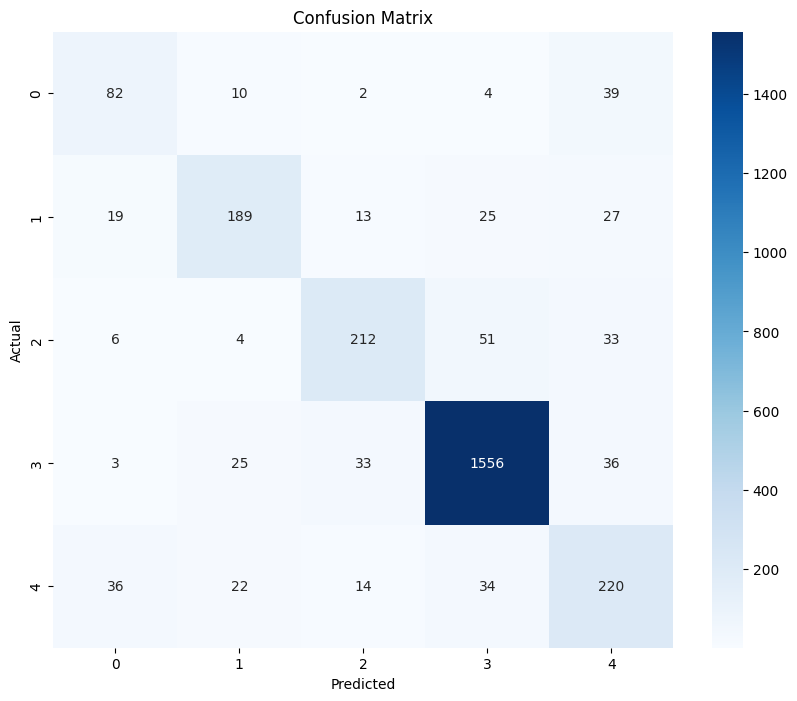

In [ ]:
# detailed evaluation and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# load best model
best_model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
model.load_state_dict(torch.load(best_model_path))
model.to(DEVICE)

val_loss, val_acc, preds, labels, probs, low_conf = validate(model, val_loader, criterion, DEVICE, collect_low_confidence=True, threshold=0.6)
logger.info(f"Final validation acc: {val_acc:.4f}")

print(classification_report(labels, preds, target_names=class_names))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

# Save predictions CSV for audit
pred_csv = "/content/val_predictions.csv"
val_image_paths = [s[0] for s in val_dataset.samples]
import csv
with open(pred_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["image_path", "true_label", "pred_label", "pred_confidence"])
    for path, true, pred, prob in zip(val_image_paths, labels, preds, probs):
        writer.writerow([path, true, pred, float(max(prob))])
logger.info("Saved detailed predictions to " + pred_csv)
logger.info(f"Low-confidence count: {len(low_conf)} (threshold=0.6)")

In [ ]:
# prepare review queue for agronomists (low-confidence)
import datetime, csv, os
REVIEW_DIR = "/content/review_queue"
os.makedirs(REVIEW_DIR, exist_ok=True)
REVIEW_CSV = os.path.join(REVIEW_DIR, "review_queue.csv")

with open(REVIEW_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["timestamp","image_path","pred_label","pred_confidence","expert_label","expert_notes"])
    for item in low_conf:
        idx = item["index_global"]
        img_path = val_image_paths[idx]
        writer.writerow([datetime.datetime.utcnow().isoformat(), img_path, item["pred"], item["conf"], "", ""])
logger.info(f"Saved review queue to {REVIEW_CSV} - hand this to agronomists for labeling")

/tmp/ipython-input-3714739164.py:13: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  writer.writerow([datetime.datetime.utcnow().isoformat(), img_path, item["pred"], item["conf"], "", ""])


In [ ]:
# export to ONNX for production/serving
!pip install onnxscript
import torch.onnx
dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
onnx_path = "/content/cassava_efficientnetb3.onnx"
model.eval()
torch.onnx.export(model, dummy, onnx_path, input_names=["input"], output_names=["output"], opset_version=18, dynamic_axes={"input":{0:"batch"}, "output":{0:"batch"}})
logger.info("Exported ONNX model to " + onnx_path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 13.0 MB/s eta 0:00:00


NameError: name 'IMG_SIZE' is not defined

In [ ]:
from google.colab import files
files.download("/content/cassava_efficientnetb3.onnx")

FileNotFoundError: Cannot find file: /content/cassava_efficientnetb3.onnx